In [1]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import matplotlib.pyplot as plt

In [47]:
def graficar_angulos_en_circulo(angulos):
    # Crear una figura y un set de ejes
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    
    # Dibujar el círculo unitario
    circulo = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    ax.add_artist(circulo)

    # Coordenadas del círculo unitario
    x_circulo = np.cos(np.linspace(0, 2 * np.pi, 100))
    y_circulo = np.sin(np.linspace(0, 2 * np.pi, 100))
    ax.plot(x_circulo, y_circulo, 'b--')  # Línea del círculo

    # Graficar los puntos correspondientes a los ángulos en el círculo unitario
    for angulo in angulos:
        x = np.cos(angulo)
        y = np.sin(angulo)
        ax.plot([0, x], [0, y], color='gray', linestyle='--')  # Línea desde el origen
        ax.plot(x, y, 'ro')  # Punto en el círculo

    # Ajustes del gráfico
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_title('Ángulos en el círculo unitario')
    
    # Dibujar los ejes
    ax.axhline(0, color='black',linewidth=0.5)
    ax.axvline(0, color='black',linewidth=0.5)

    # Mantener proporciones iguales
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()


In [2]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)
print(archivos_en_carpeta)
index0 = 0
indice = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas
    datos_composers[composer]['Indice'] = indice
    indice += 1

datos_composers_df = pd.DataFrame(datos_composers)
print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])
print(datos_composers_df)    

['1397-dufay-Labels.txt', '1500-morales-Labels.txt', '1521-desprez-Labels.txt', '1525-palestrina-Labels.txt', '1532-lasso-Labels.txt', '1538-byrd-Labels.txt', '1548-victoria-Labels.txt', '1557-gabrielis-Labels.txt', '1563-dowland-Labels.txt', '1566-gesualdo-Labels.txt', '1567-monteverdi-Labels.txt', '1583-frescobaldi-Labels.txt', '1587-scheidt-Labels.txt', '1616-froberger-Labels.txt', '1629-anglebert-Labels.txt', '1632-lully-Labels.txt', '1637-buxtehude-Labels.txt', '1653-pachelbel-Labels.txt', '1668-couperin-Labels.txt', '1671-albinoni-Labels.txt', '1678-vivaldi-Labels.txt', '1681-telemann-Labels.txt', '1682-dandrieu-Labels.txt', '1683-rameau-Labels.txt', '1685-handel-Labels.txt', '1685-scarlatti-Labels.txt', '1688-zipoli-Labels.txt', '1721-bach-js-Labels.txt', '1732-haydn-Labels.txt', '1736-albrechtsberger-Labels.txt', '1752-clementi-Labels.txt', '1756-mozart-Labels.txt', '1770-beethoven-Labels.txt', '1771-cramer-Labels.txt', '1782-paganini-Labels.txt', '1797-schubert-Labels.txt', '1

C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_8624\1761750877.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])


In [3]:
composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze().to_numpy().astype(float) # agregamos pieza al dicc composer con key como # serie
print('Número total de elementos de todo el dataset: ', M)

Número total de elementos de todo el dataset:  8250485


In [4]:
import copy
def midi_to_hz(midi_notes):
    # Fórmula para convertir número MIDI a Hz
    freqs = 440.0 * 2 ** ((midi_notes - 69) / 12.0)
    return freqs

# composers_interp = copy.deepcopy(composers)
composers_Hz = copy.deepcopy(composers)

for composer in composers_Hz.keys():
    for pieza in composers_Hz[composer].keys():
        subject = composers[composer][pieza]
        composers_Hz[composer][pieza] = midi_to_hz(subject)

In [5]:
composers_Hz_depurado = copy.deepcopy(composers_Hz)
datos_composers_Hz_depurado = copy.deepcopy(datos_composers)

for composer in composers_Hz.keys():
    d = 0
    for pieza in composers_Hz[composer].keys():
        if len(composers_Hz[composer][pieza])//2 < 400:
            del composers_Hz_depurado[composer][pieza]
            d = d + 1
    datos_composers_Hz_depurado[composer]['# Piezas'] = datos_composers[composer]['# Piezas'] - d
    print(f"Piezas eliminadas de {composer} = {d}, de {datos_composers[composer]['# Piezas']} Piezas ({datos_composers[composer]['# Piezas'] - d} Total)")            


Piezas eliminadas de Dufay = 13, de 13 Piezas (0 Total)
Piezas eliminadas de Morales = 87, de 88 Piezas (1 Total)
Piezas eliminadas de Desprez = 35, de 35 Piezas (0 Total)
Piezas eliminadas de Palestrina = 61, de 61 Piezas (0 Total)
Piezas eliminadas de Lasso = 70, de 70 Piezas (0 Total)
Piezas eliminadas de Byrd = 56, de 109 Piezas (53 Total)
Piezas eliminadas de Victoria = 326, de 326 Piezas (0 Total)
Piezas eliminadas de Gabrielis = 23, de 23 Piezas (0 Total)
Piezas eliminadas de Dowland = 61, de 61 Piezas (0 Total)
Piezas eliminadas de Gesualdo = 37, de 37 Piezas (0 Total)
Piezas eliminadas de Monteverdi = 20, de 20 Piezas (0 Total)
Piezas eliminadas de Frescobaldi = 93, de 104 Piezas (11 Total)
Piezas eliminadas de Scheidt = 8, de 8 Piezas (0 Total)
Piezas eliminadas de Froberger = 49, de 60 Piezas (11 Total)
Piezas eliminadas de Anglebert = 54, de 67 Piezas (13 Total)
Piezas eliminadas de Lully = 102, de 103 Piezas (1 Total)
Piezas eliminadas de Buxtehude = 48, de 94 Piezas (46 T

In [6]:
# 40 promedio de numero de piezas por compositor
composers_Hz_depurado_v2 = copy.deepcopy(composers_Hz_depurado)
datos_composers_Hz_depurado_v2 = copy.deepcopy(datos_composers_Hz_depurado)

for composer in composers.keys():
    if datos_composers_Hz_depurado[composer]['# Piezas'] < 30:
        del composers_Hz_depurado_v2[composer]
        del datos_composers_Hz_depurado_v2[composer]
print(" # de compositores restantes: ", len(composers_Hz_depurado_v2))

 # de compositores restantes:  19


In [16]:
"""Ahora nos quedamos con número de piezas iguales para todos los 17 compositores"""

fa = np.array([datos_composers_Hz_depurado_v2[composer]['# Piezas'] for composer in composers_Hz_depurado_v2.keys()])


# Calculos

In [230]:
# Js = np.full((19,2160), np.nan)
# for x, composer in enumerate(composers_Hz_depurado_v2):
#     for y, serie in enumerate(composers_Hz_depurado_v2[composer]):
#         f = composers_Hz_depurado_v2[composer][serie]
#         Js[x,y] = J_univariante(f, 1, False)
#     print(composer)
# np.save('J_composers_Hz_depurado.npy', Js)
"""Se calculó la J para cada compositor de cada serie inalterada en el numpy array Js  como J_composers_Hz_depurado.npy"""

Byrd
Buxtehude
Handel
Scarlatti
Bach
Haydn
Mozart
Beethoven
Schubert
Chopin
Schumann
Liszt
Alkan
Brahms
Saint
Tchaikovsky
Dvorak
Faure
Debussy


'Se calculó la J para cada compositor de cada serie inalterada en el numpy array Js  como J_composers_Hz_depurado.npy'

In [7]:
fa = np.array([datos_composers_Hz_depurado_v2[composer]['# Piezas'] for composer in composers_Hz_depurado_v2.keys()])
print(np.max(fa) + 1)
len(composers_Hz_depurado_v2)

518


19

In [19]:
# Ns = np.full((19,518), np.nan)
# for x, composer in enumerate(composers_Hz_depurado_v2):
#     for y, serie in enumerate(composers_Hz_depurado_v2[composer]):
#         Ns[x,y] = len(composers_Hz_depurado_v2[composer][serie])
# np.save('Ns_depurado.npy', Ns)

"""Se guardó la el tamaño de cada serie en Ns_depurado.npy"""

'Se guardó la el tamaño de cada serie en Ns_depurado.npy'

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(y,window_size):
    window_size = window_size
    threshold_high = 2.3
    threshold_low = -2.3

    transition_point = None

    # Desplazar la ventana a lo largo del array
    for i in range(len(y) - window_size):
        window = y[i:i + window_size]
        
        # Verificar si hay valores por arriba de 2.5 o por abajo de -2.5
        if not np.any(window >= threshold_high) and not np.any(window <= threshold_low):
            transition_point = i
            break
        else:
            continue 

    return transition_point

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        transition_point1 = arm_detector(ff1, 500)
        transition_point2 = arm_detector(ff2, 500)
        if transition_point2 is not None:
            ff2 = ff2[:transition_point2]
        elif transition_point2 is None:
            transition_point2 = len(ff2)
        if transition_point1 is not None and transition_point1 < transition_point2:
            ff1 = ff1[:transition_point1]
        else:
            ff1 = ff1[:transition_point2]

    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

In [20]:
print(datos_composers_Hz_depurado_v2.keys())

dict_keys(['Byrd', 'Buxtehude', 'Handel', 'Scarlatti', 'Bach', 'Haydn', 'Mozart', 'Beethoven', 'Schubert', 'Chopin', 'Schumann', 'Liszt', 'Alkan', 'Brahms', 'Saint', 'Tchaikovsky', 'Dvorak', 'Faure', 'Debussy'])


In [242]:
"""Compute everything"""

import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator


#################
for composer in composers_Hz_depurado_v2.keys():


    J_interp_hermite = []

    for subject in composers_Hz_depurado_v2[composer].values():


        x_new, interp_herm = interpolador(subject, 'herm', 5)

        J_herm = J_univariante(interp_herm, 1, True)

        J_interp_hermite.append(J_herm)

    np.save('J_hermite_cortado_depurado/'+ str(datos_composers[composer]['Birth_year']) + '_J_interp_' + str(composer) + '_herm.npy', np.array(J_interp_hermite))
    print(composer)

Byrd
Buxtehude
Handel
Scarlatti
Bach
Haydn
Mozart
Beethoven
Schubert
Chopin
Schumann
Liszt
Alkan
Brahms
Saint
Tchaikovsky
Dvorak
Faure
Debussy


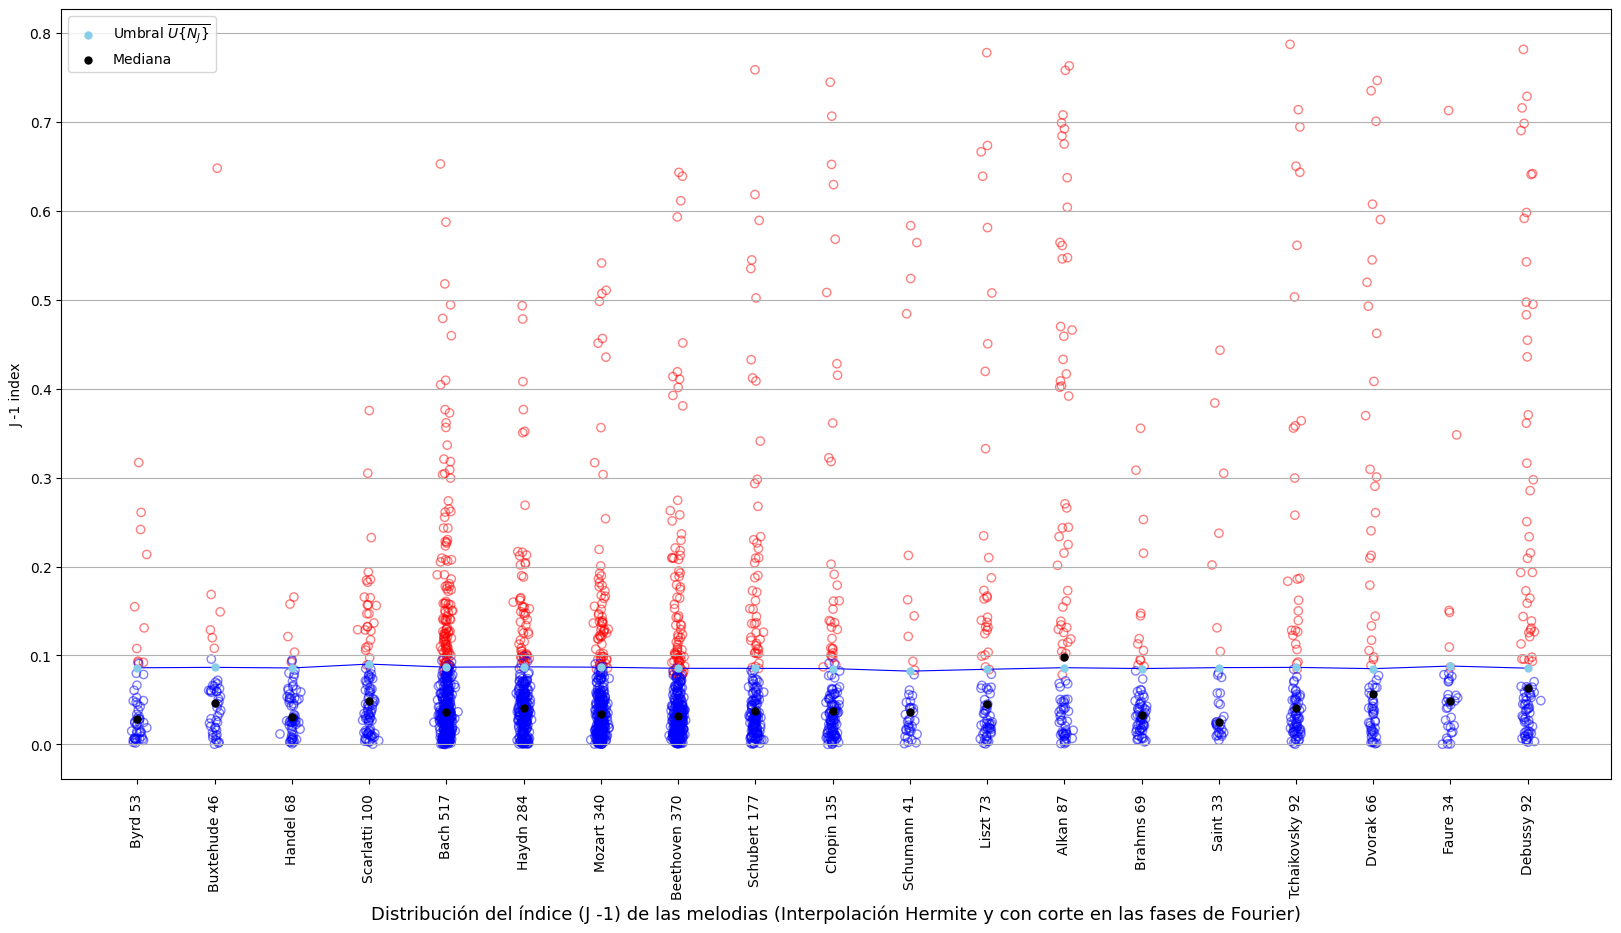

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

num_compositores = 19
Ns = np.load('Ns_depurado.npy')//2
J_minus_2000 = np.load('J_minus_2000.npy')

carpeta1 = 'J_lineal_cortado_depurado' 
carpeta2 = 'J_hermite_cortado_depurado' 

archivos_en_carpeta1 = os.listdir(carpeta1)
archivos_en_carpeta2 = os.listdir(carpeta2)

data1 = [1 - np.sort(np.load(os.path.join(carpeta1, array)))[:] for array in archivos_en_carpeta1]
data2 = [1 - np.sort(np.load(os.path.join(carpeta2, array)))[:] for array in archivos_en_carpeta2]
Ns_data = [Ns[array] for array in range(np.shape(Ns)[0])]
J_OG = [1 - np.load('J_composers_Hz_depurado.npy')[array] for array in range(np.shape(Ns)[0])]

data1 = [array[~np.isnan(array)] for array in data1]
data2 = [array[~np.isnan(array)] for array in data2]
Ns_data = [array[~np.isnan(array)] for array in Ns_data]
J_OG = [array[~np.isnan(array)] for array in J_OG]


for j in range(num_compositores):
    for i in range(len(Ns_data[j])):
        if Ns_data[j][i] >= 2000:
            Ns_data[j][i] = 1999

umbral = [[J_minus_2000[int(i) - 20] for i in Ns_data[j]] for j in range(num_compositores)]

# Aquí, asume que `puntos` es la lista con los num_compositores elementos
puntos1 = [J_minus_2000[int(np.mean(Ns_data[j])) - 20] for j in range(num_compositores)]
puntos2 = [np.mean(np.array([1 - J_minus_2000[int(i) - 20] for i in Ns_data[j]])) for j in range(num_compositores)]
mediana = [np.median(array) for array in data2]

fig, ax = plt.subplots(figsize=(20, 10))
# box2 = ax.boxplot(data2, patch_artist=True)

for i, (d, u) in enumerate(zip(data2, umbral)):
    # Añadir dispersión para evitar superposición
    x = np.random.normal(i + 1, 0.04, size=len(d))
    colors = ['blue' if d_val < u_val else 'red' for d_val, u_val in zip(d, [1-x for x in u])]
    plt.scatter(x, d, alpha=0.5, color='none', edgecolors=colors)

ax.set_xlabel(f'Distribución del índice (J -1) de las melodias (Interpolación Hermite y con corte en las fases de Fourier)', fontsize=13)
ax.set_ylabel('J -1 index')
ax.set_xticks(np.arange(1, num_compositores+1))

# ax.scatter(np.arange(1, 78), puntos1, color='red', s=50, zorder=3, marker = '*', label=r'$U\{\overline{N_J}\}$')
ax.scatter(np.arange(1, num_compositores+1), puntos2, color='#87CEEB', s=25, zorder=3, marker = 'o', label=r'Umbral $\overline{U\{ N_J \}}$')
ax.scatter(np.arange(1, num_compositores+1), mediana, color='black',s=25,zorder=3,marker='o',label='Mediana')
ax.plot(np.arange(1, num_compositores+1), puntos2, color='blue', linestyle='-', linewidth=0.8)
# ax.plot(np.arange(1, 18), mediana, color='red', linestyle='-', linewidth=0.8)

ax.legend()
ax.set_xticklabels([f"{composer} {datos_composers_Hz_depurado_v2[composer]['# Piezas']} " for i, composer in enumerate(datos_composers_Hz_depurado_v2.keys())], rotation=90)


plt.grid(axis='y')
plt.show()

2677 2677 2677


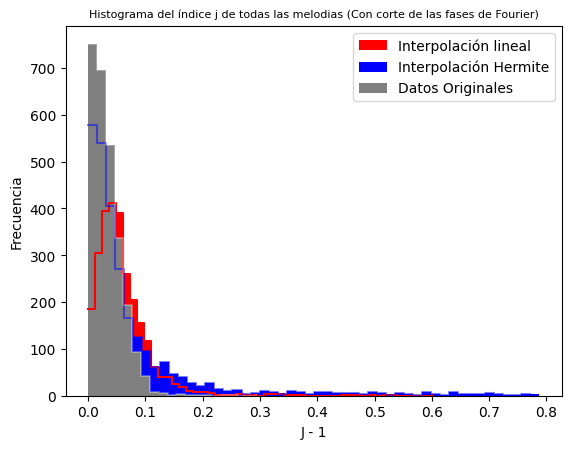

In [48]:
import matplotlib.pyplot as plt
import numpy as np

data1_flat = np.concatenate(data1)
data2_flat = np.concatenate(data2)
OG_data_flat = np.concatenate(J_OG)
print(len(OG_data_flat),len(data2_flat),len(data1_flat))
# Crear histogramas y obtener los valores de las barras
counts1, bins1, _ = plt.hist(data1_flat, bins=50, color='red', alpha=1, edgecolor='none', label='Interpolación lineal')
counts2, bins2, _ = plt.hist(data2_flat, bins=50, color='blue', alpha=1, edgecolor='none', label='Interpolación Hermite')
counts3, bins3, _ = plt.hist(OG_data_flat, bins=20, color='gray',alpha=1, edgecolor='none', label='Datos Originales')

# Dibujar los contornos superiores de cada histograma
plt.plot(bins1[:-1], counts1, drawstyle='steps-post', color='red')
plt.plot(bins2[:-1], counts2, drawstyle='steps-post', color='blue',alpha = 0.5)
plt.plot(bins3[:-1], counts3, drawstyle='steps-post', color='white',alpha = 0.3)

# Personalizar la gráfica
plt.xlabel('J - 1')
plt.ylabel('Frecuencia')
plt.title('Histograma del índice j de todas las melodias (Con corte de las fases de Fourier)', fontsize=8)
plt.legend()
plt.show()


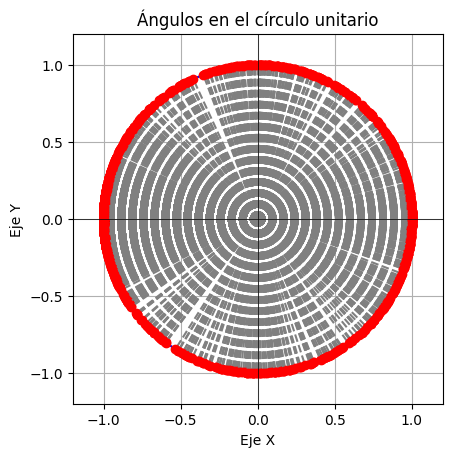

Serie_7 Schubert 0.24139216186903145


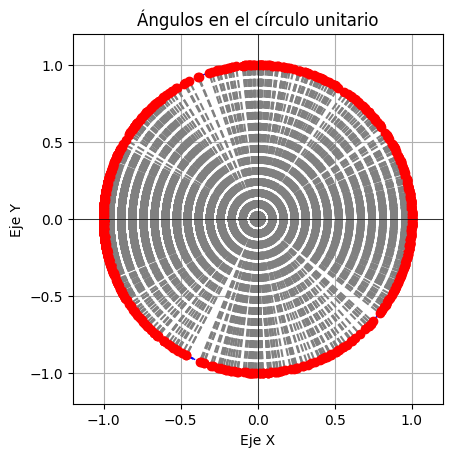

Serie_125 Chopin 0.2553248433631735


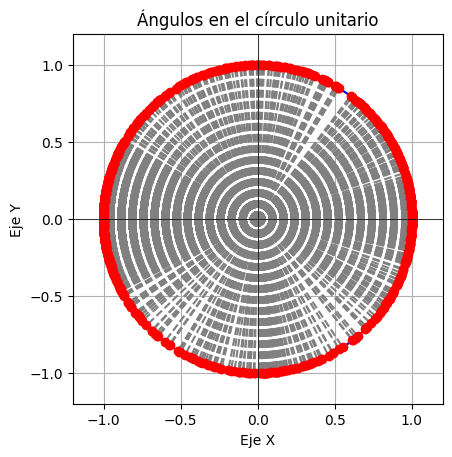

Serie_152 Chopin 0.2935404722055216


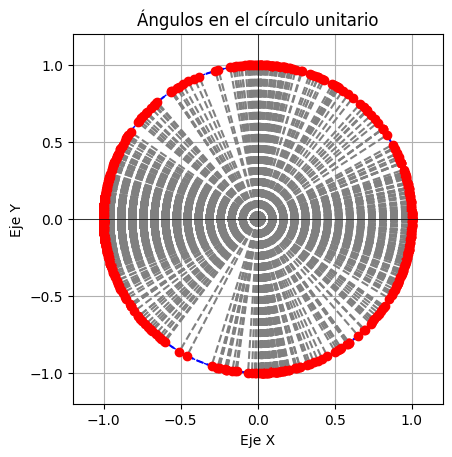

Serie_22 Liszt 0.2221327751689809


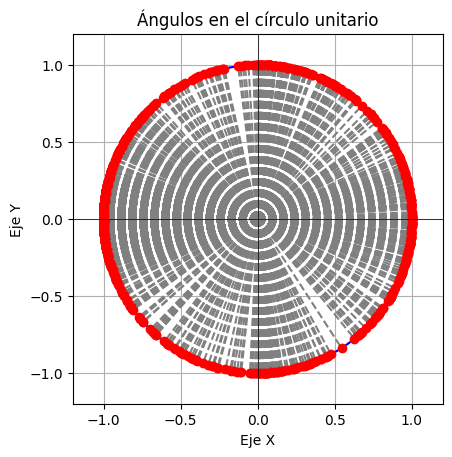

Serie_42 Alkan 0.2921557791250926


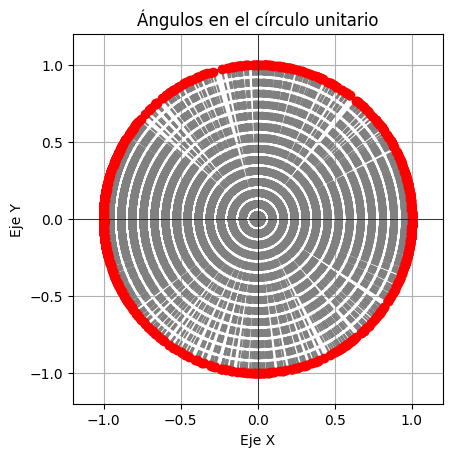

Serie_114 Alkan 0.2369590178883234


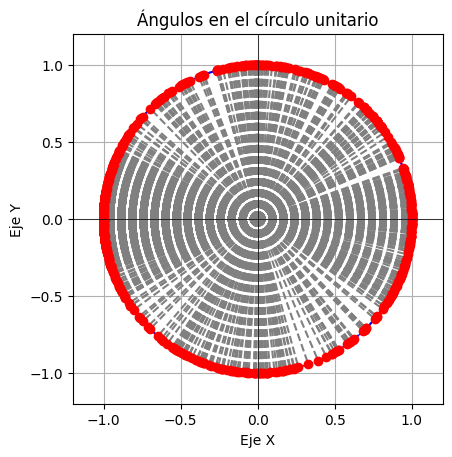

Serie_120 Alkan 0.2420362401624706


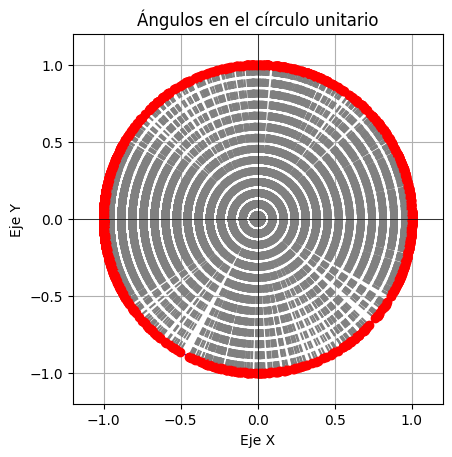

Serie_120 Tchaikovsky 0.21278802597606017


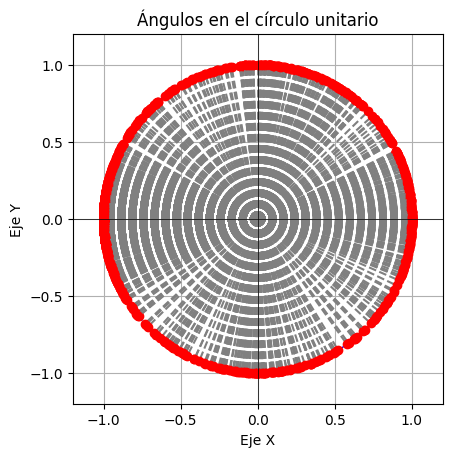

Serie_126 Tchaikovsky 0.2862876783184666


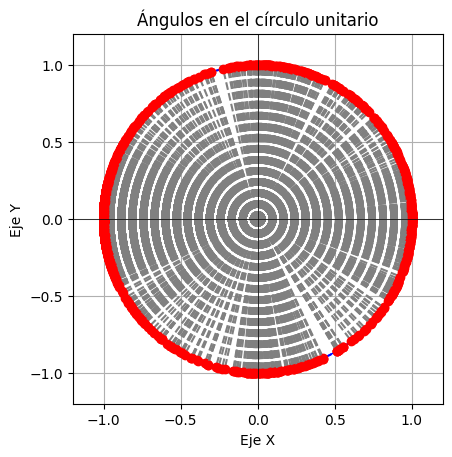

Serie_48 Dvorak 0.2993093687289238


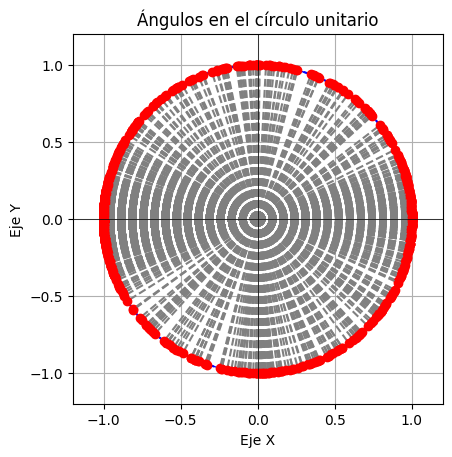

Serie_49 Dvorak 0.25345071136651387


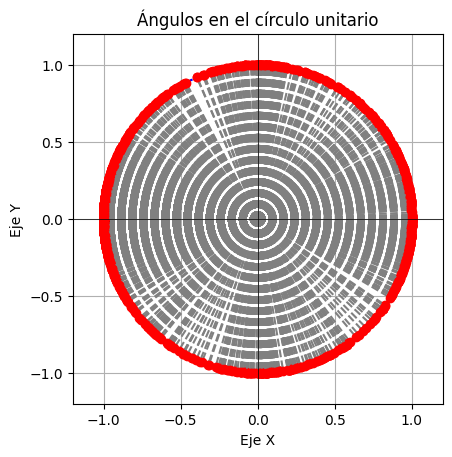

Serie_50 Dvorak 0.26492782602199083


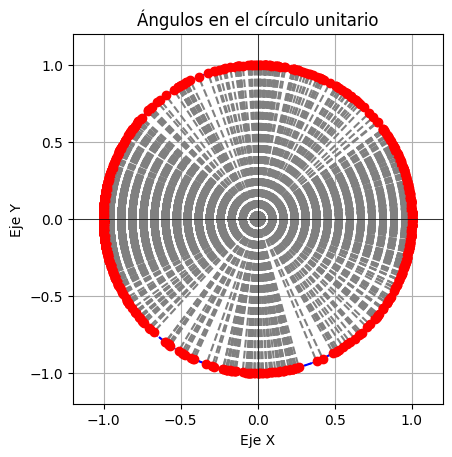

Serie_43 Faure 0.28721087447750404


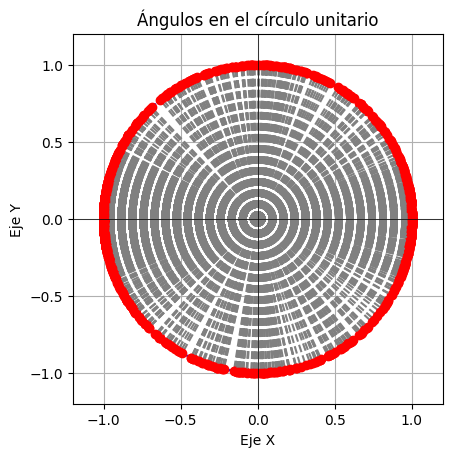

Serie_16 Debussy 0.2842262015947201


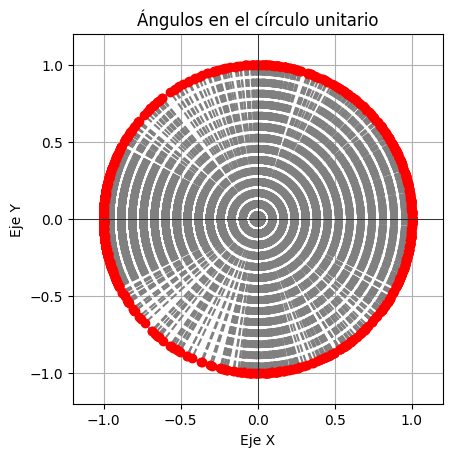

Serie_18 Debussy 0.2712417581019252


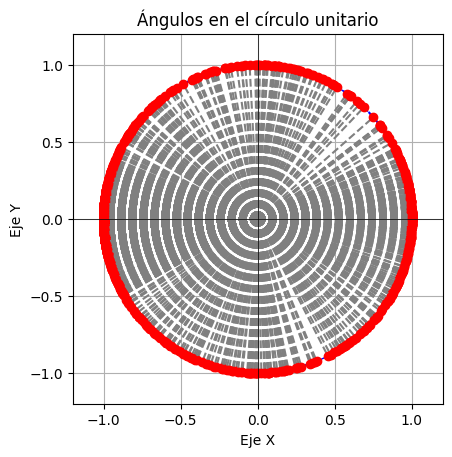

Serie_166 Debussy 0.2184451709854066


In [52]:
for composer in composers_Hz_depurado_v2.keys():
    for pieza in composers_Hz_depurado_v2[composer].keys():
        subject = composers_Hz_depurado_v2[composer][pieza]
        j, angulos = J_univariante(interpolador(subject, 'herm', 5)[1], 1, True)
        if j < 0.3:
            graficar_angulos_en_circulo(angulos)
            print(pieza, composer, j)

In [272]:
data2 = np.load('J_hermite_cortado_depurado/1721_J_interp_Bach_herm.npy')

# data2 = np.load('J_composers_Hz_depurado.npy')[12,:]
# data2 = data2[~np.isnan(data2)]

piezas = [pieza for pieza in composers_Hz_depurado_v2['Bach'].keys()]

aver = np.array([[data2[i], piezas[i], count_consecutive_repeats(interpolador(composers_Hz_depurado_v2['Bach'][piezas[i]], 'herm', 5)[1])] for i in range(len(data2))])
array_duplas_ordenado = aver[aver[:, 0].argsort()]

print(array_duplas_ordenado)

spearman_corr, _ = spearmanr(array_duplas_ordenado[:,0], array_duplas_ordenado[:,2])
# pearson_corr = np.corrcoef(array_duplas_ordenado[:,2], array_duplas_ordenado[:,2])[0, 1]
print(spearman_corr)

[['0.34726301016318706' 'Serie_1213' '18']
 ['0.4126654035752142' 'Serie_2153' '96']
 ['0.4821541414784991' 'Serie_1426' '12']
 ...
 ['0.999877374621563' 'Serie_1217' '210']
 ['0.9999516035196028' 'Serie_1882' '18']
 ['0.9999741576444829' 'Serie_1076' '408']]
0.04815550952938409


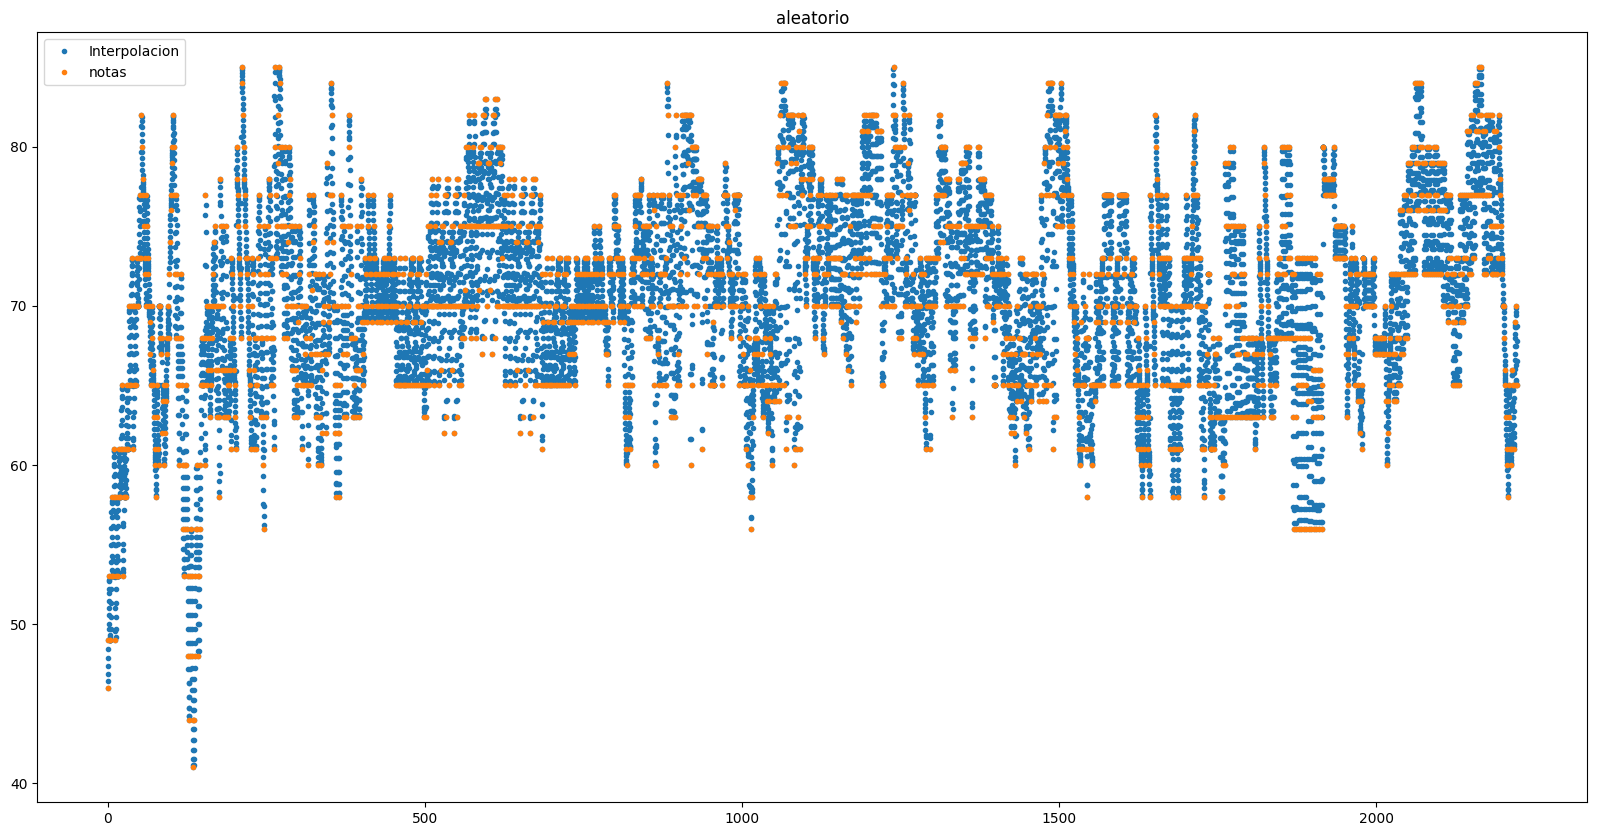

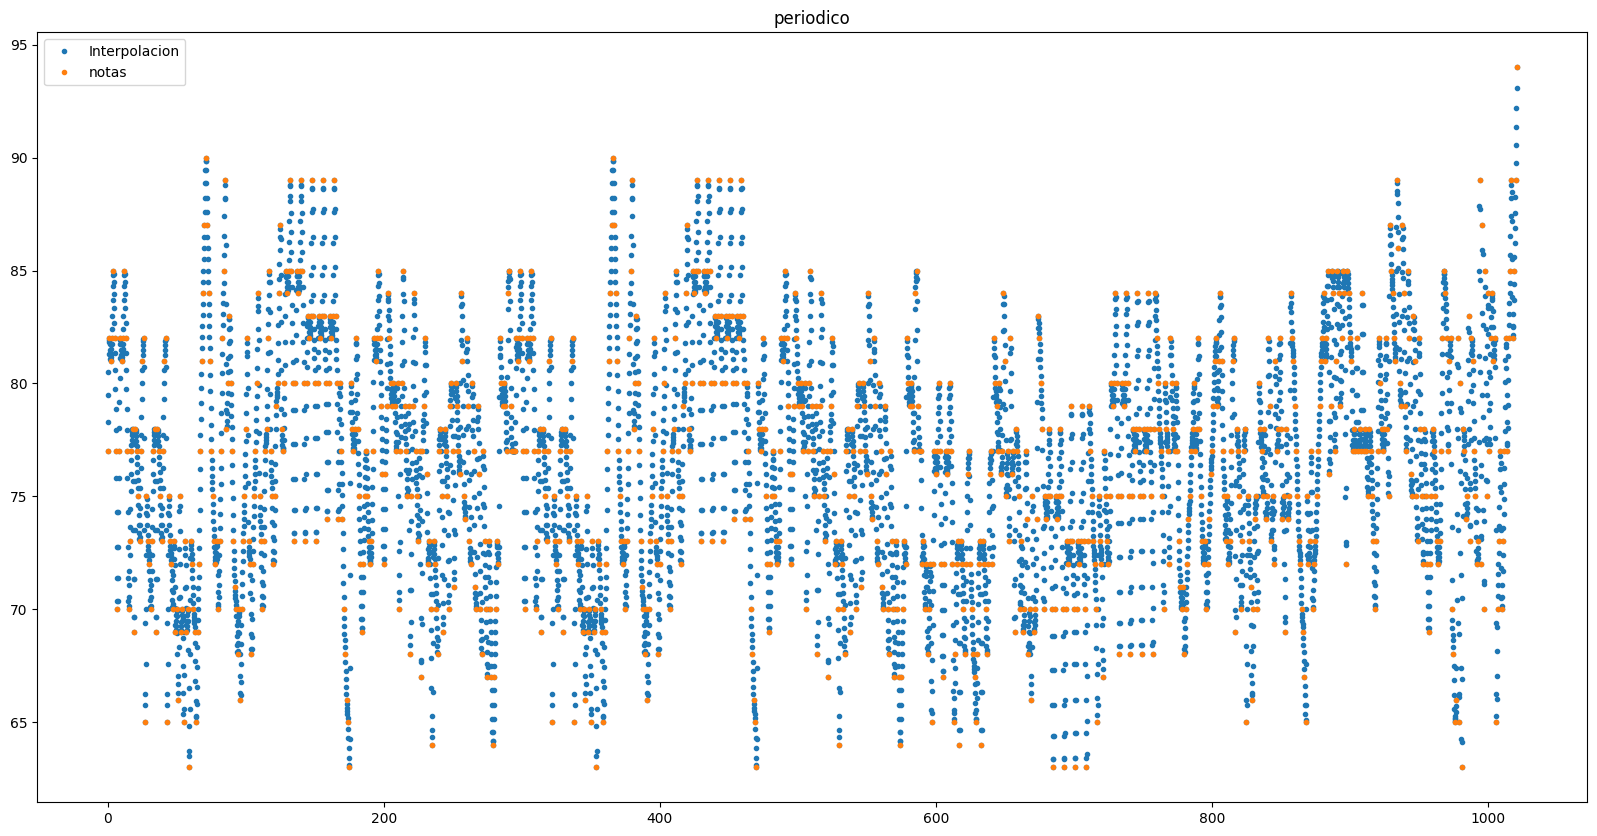

0.2369590178883234


In [274]:
import numpy as np
from mido import Message, MidiFile, MidiTrack

array_notas_periodico = composers['Bach']['Serie_1213']
array_notas_aleatorio = composers['Bach']['Serie_1076']

def midi_creator(array_notas, nombre):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    # Agregar un mensaje MIDI "program_change" para seleccionar el instrumento (opcional)
    track.append(Message('program_change', program=12, time=0))

    # Asumir una duración fija para cada nota (en ticks)
    duracion_fija = 480  # Puedes cambiar la duración como desees

    # Convertir el array en eventos MIDI
    for nota in array_notas:
        # Nota ON
        track.append(Message('note_on', note=int(nota), velocity=64, time=0))
        # Nota OFF después de la duración fija
        track.append(Message('note_off', note=int(nota), velocity=64, time=duracion_fija))

    # Guardar el archivo MIDI
    mid.save(nombre + '.midi')

midi_creator(array_notas_aleatorio, 'aleatorio')
midi_creator(array_notas_periodico, 'periodico')

fig = plt.subplots(figsize=(20, 10))
fafe = interpolador(array_notas_aleatorio[:],'herm',5)
plt.plot(fafe[0], fafe[1], '.', label = 'Interpolacion')
plt.plot(array_notas_aleatorio[:], '.', label='notas')
plt.legend()
plt.title('aleatorio')
plt.show()
fig= plt.subplots(figsize=(20, 10))
fafe = interpolador(array_notas_periodico[:],'herm',5)
plt.plot(fafe[0], fafe[1], '.', label = 'Interpolacion')
plt.plot(array_notas_periodico[:], '.', label='notas')
plt.legend()
# plt.xlim(0,25)
plt.title('periodico')
plt.show()
# print()

